In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import pearsonr

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
os.chdir('/media/ivan/Extreme SSD/DMS v ABE Manuscript/Verification Screen Fig4')

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [ ]:
os.chdir(###Working DIrectory Goes Here)

In [2]:
#Statistical cutoffs for growth rates 
ABE_2SD = 0.0541397227562014 #2SD from targeting control sgRNA
DMS_2SD = 0.04475679365950399 #2SD from null gussian mixture model

## sgRNA vs Edit GR

In [4]:
ABE_Veri_Seq = pd.read_csv('ABE_Veri_DMS_above_background.csv')
ABE_Veri_Seq['MultiAA'] =  ABE_Veri_Seq['mut'].str.len() > 5
ABE_Veri_Seq['sgName'] = ABE_Veri_Seq['sgRNA'].str[2:-2]
ABE_Veri_Seq = ABE_Veri_Seq[['mut', 'D0', 'Veri_growthrate_D6','ABE_Activity', 'DMS_Predicedted_Mutations', 'within_editing_window', 'MultiAA', 'sgName']]
ABE_Veri_Seq.columns = ['mut', 'Veri_mut_freq','Veri_mut_growthrate','ABE_Activity', 'DMS_mut_growthrate', 'within_editing_window', 'MultiAA', 'sgName']

ABE_Veri_sgRNA = pd.read_csv('ABE_Veri_DESeq2.csv')
ABE_Veri_sgRNA = ABE_Veri_sgRNA[['sgName', 'Veri_growthrate', 'Veri_D0_Freq']]
ABE_Veri_sgRNA.columns = ['sgName', 'Veri_sgRNA_growthrate', 'Veri_sgRNA_freq']

ABE_Veri_Seq_sgRNA = pd.merge(ABE_Veri_sgRNA, ABE_Veri_Seq, on='sgName', how='outer')
Veri_DF = ABE_Veri_Seq_sgRNA.dropna()
Veri_DF['DMS_Predicedted_Mutations'] = Veri_DF['DMS_mut_growthrate'].astype(float)
Veri_DF['DMS_Dropout'] = Veri_DF['DMS_Predicedted_Mutations'] < DMS_2SD
Veri_DF_single = Veri_DF.loc[Veri_DF['MultiAA']==False]
Veri_DF_singles = Veri_DF.loc[Veri_DF['mut'].str.len() < 6]

/tmp/ipykernel_308918/3545935630.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Veri_DF['DMS_Predicedted_Mutations'] = Veri_DF['DMS_mut_growthrate'].astype(float)
/tmp/ipykernel_308918/3545935630.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Veri_DF['DMS_Dropout'] = Veri_DF['DMS_Predicedted_Mutations'] < DMS_2SD


In [5]:
Veri_DF_singles.head()

,sgName,Veri_sgRNA_growthrate,Veri_sgRNA_freq,mut,Veri_mut_freq,Veri_mut_growthrate,ABE_Activity,DMS_mut_growthrate,within_editing_window,MultiAA,DMS_Predicedted_Mutations,DMS_Dropout
0,BCRABL_1776,0.053798,0.019475,L248P,0.015735,0.035222,A > G,0.0117471339013615,True,False,0.011747,True
2,BCRABL_1792,0.054497,0.048364,Q252R,0.006390,0.038384,A > G,0.0261731935396602,True,False,0.026173,True
4,BCRABL_1792,0.054497,0.048364,Y253C,0.001310,0.040772,A > G,0.0202111627185439,True,False,0.020211,True
5,BCRABL_1800,0.054557,0.025172,Y257C,0.002089,0.037777,A > G,0.0144385212342322,True,False,0.014439,True
6,BCRABL_1808,0.056737,0.064944,Y264C,0.000671,0.054116,A > G,0.0661430543408558,True,False,0.066143,False


In [6]:
# Note the difference in argument order
Y = Veri_DF_singles['Veri_sgRNA_growthrate']
X = Veri_DF_singles['Veri_mut_growthrate']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

rmse(Veri_DF_single['Veri_sgRNA_growthrate'], Veri_DF_single['Veri_mut_growthrate']*results.params[1] + results.params[0])

0.0005440717954065601

In [17]:
Veri_DF_singles[[sgRNA'Veri_mut_growthrate', 'Veri_sgRNA_growthrate']].drop_duplicates().corr()

,Veri_mut_growthrate,Veri_sgRNA_growthrate
Veri_mut_growthrate,1.000000,0.766604
Veri_sgRNA_growthrate,0.766604,1.000000


In [18]:
sg_min = Veri_DF_singles[['sgName', 'Veri_sgRNA_growthrate', 'Veri_mut_growthrate']].groupby(['sgName', 'Veri_sgRNA_growthrate']).min().reset_index()
sg_min.columns =['sgName', 'Veri_sgRNA_growthrate', 'DMS_min']
sg_max = Veri_DF_singles[['sgName','Veri_mut_growthrate']].groupby(['sgName']).max().reset_index()
sg_max.columns =['sgName', 'DMS_max']

sg_min_max = pd.merge(sg_min, sg_max, on='sgName')

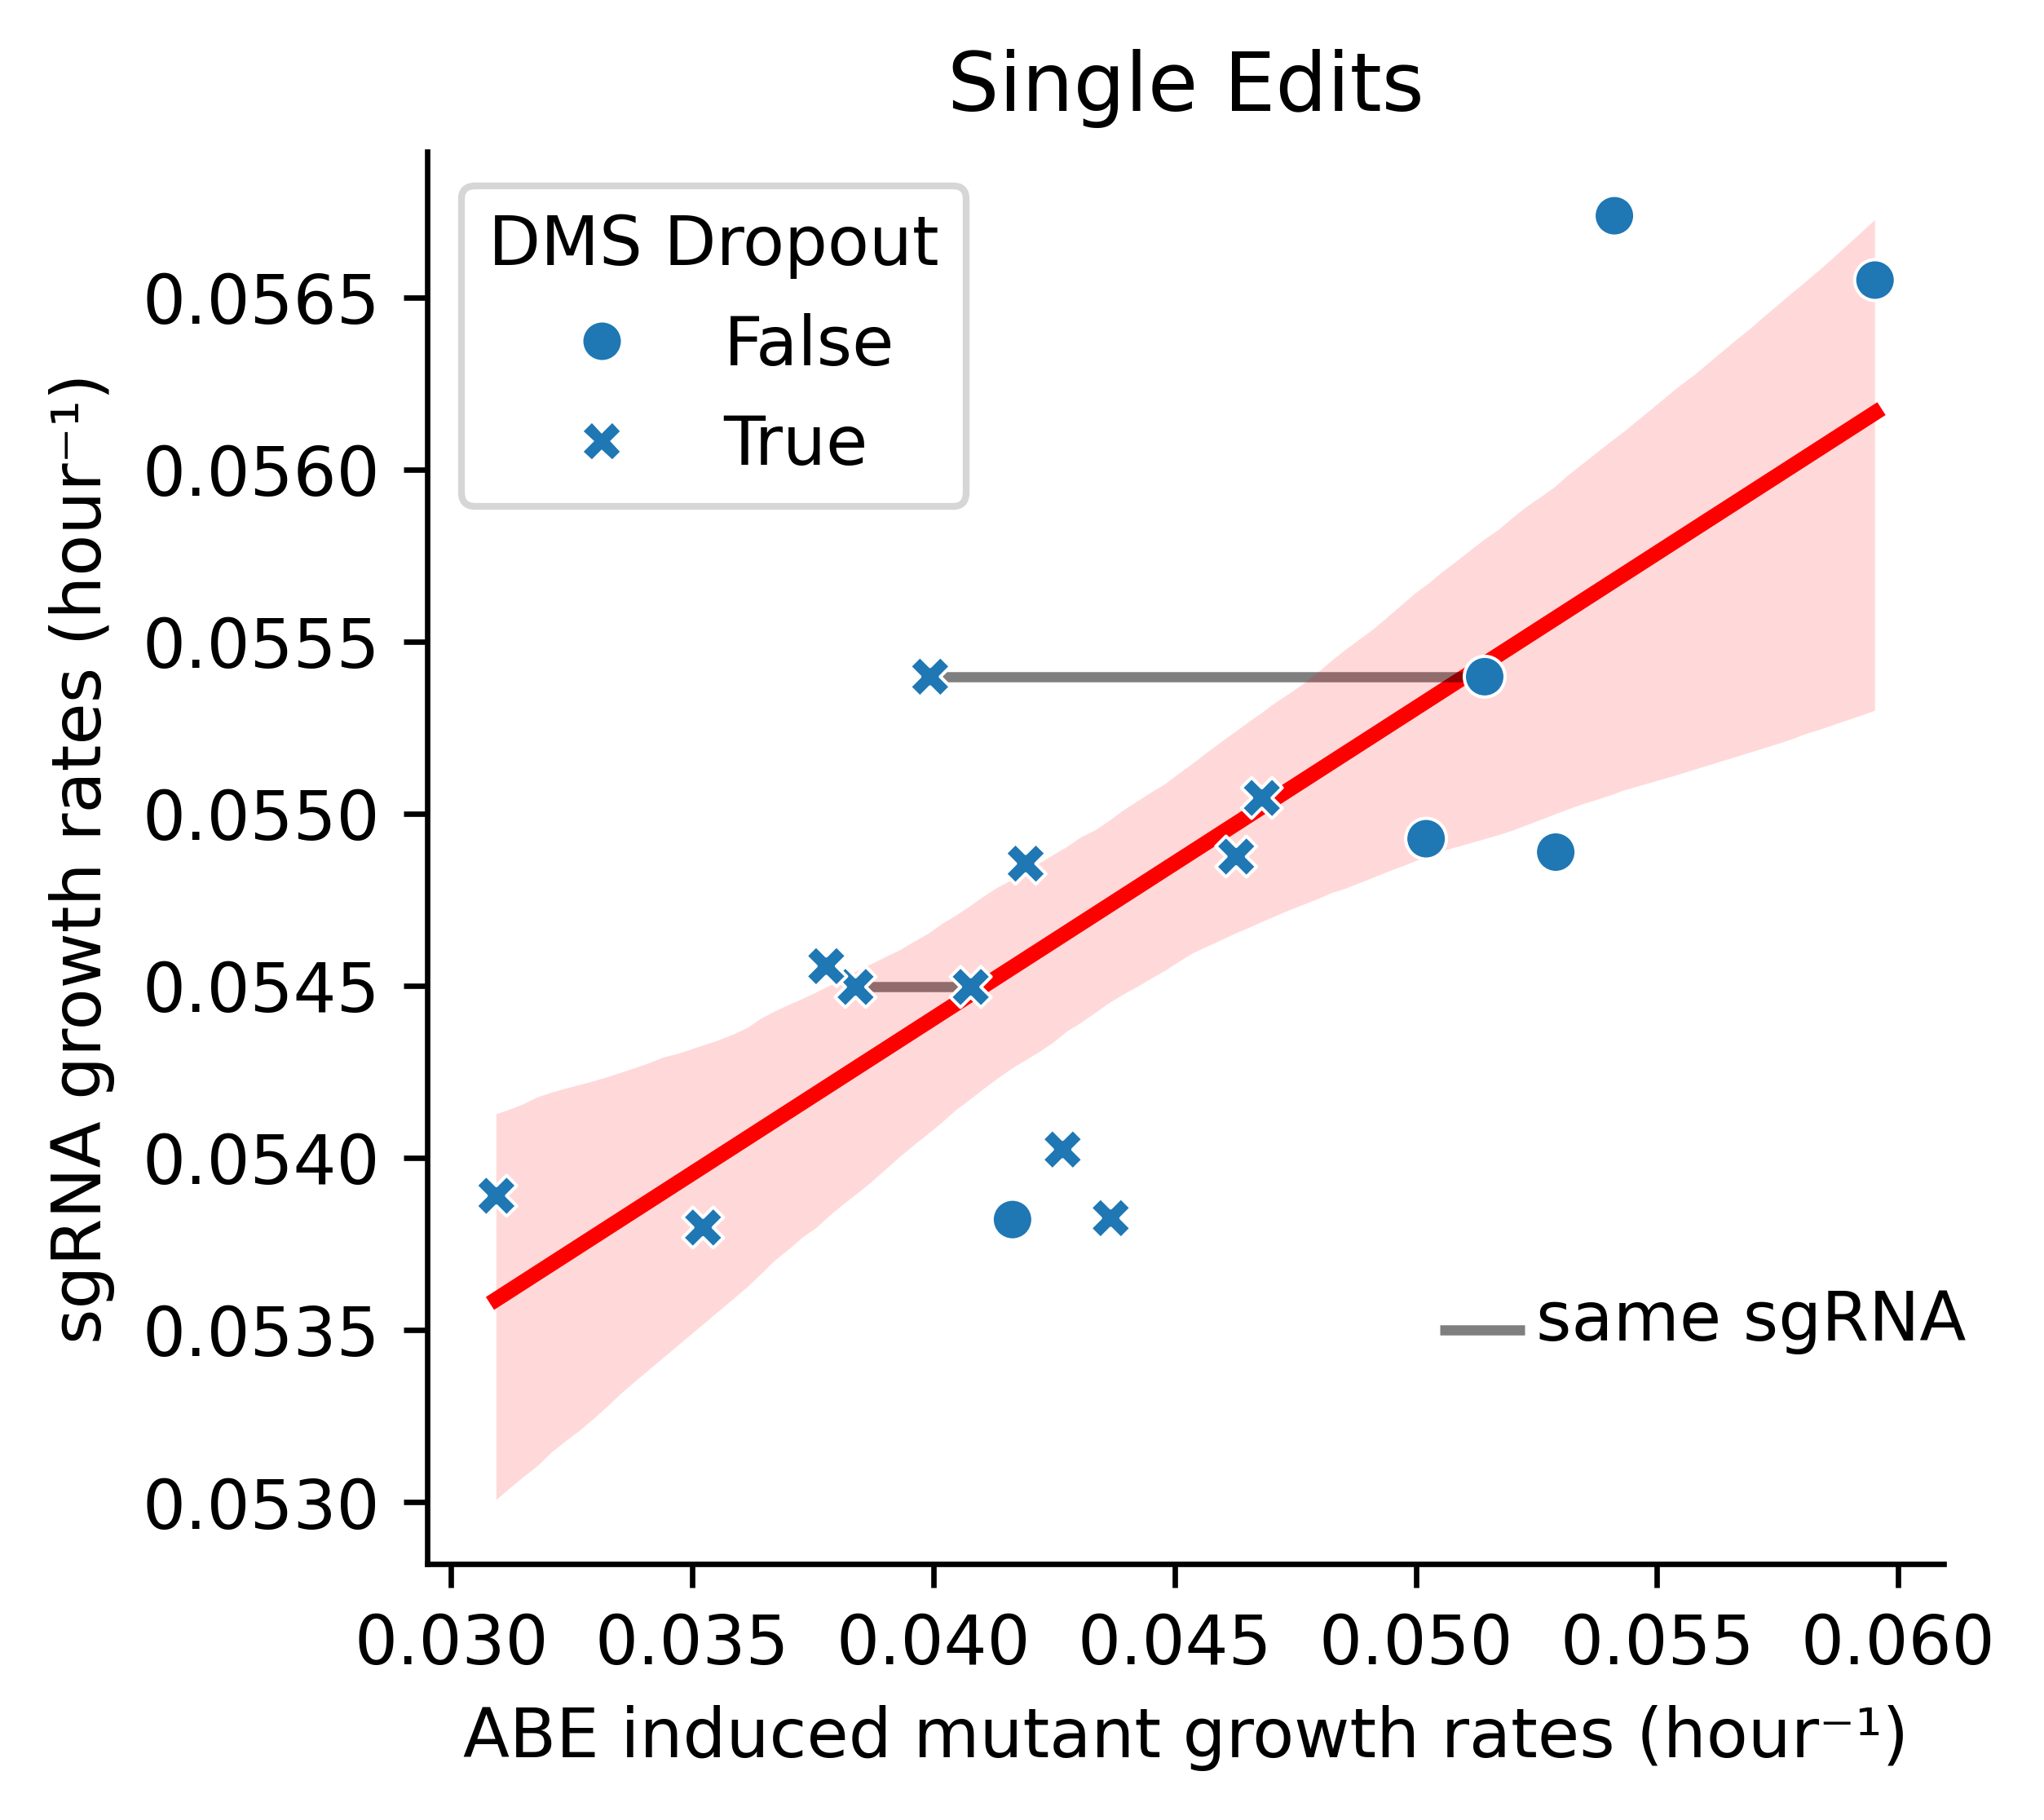

In [20]:
plt.figure(figsize=(4,3.75), dpi=600)
Veri_sgRNA = sns.regplot(x='Veri_mut_growthrate', y='Veri_sgRNA_growthrate', scatter_kws={'alpha':0} , line_kws={"color": "red", "zorder":0} ,data=Veri_DF_single)
Veri2 = sns.scatterplot(x='Veri_mut_growthrate', y='Veri_sgRNA_growthrate', style='DMS_Dropout', data=Veri_DF_single)
Veri_sgRNA.set(xlabel='ABE induced mutant growth rates (hour⁻¹)', ylabel='sgRNA growth rates (hour⁻¹)', title='Single Edits')
plt.hlines(sg_min_max['Veri_sgRNA_growthrate'], sg_min_max['DMS_min'], sg_min_max['DMS_max'], alpha=0.5, color='black', zorder=0)
plt.hlines(0.0535, 0.0505, 0.05225, alpha=0.5, color='black', zorder=0)
Veri2.text(0.0525, 0.05347,'same sgRNA')
Veri2.legend(title='DMS Dropout')
sns.despine()
#Veri_sgRNA.get_figure().savefig("Single Veri mut vs Veri sgRNA REgression lollipop GR0625.png" , bbox_inches='tight', transparent=True) 

In [21]:
# Note the difference in argument order
Y = Veri_DF_singles['Veri_mut_growthrate']
X = Veri_DF_singles['DMS_Predicedted_Mutations']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

rmse(Veri_DF_single['Veri_mut_growthrate'], Veri_DF_single['DMS_Predicedted_Mutations']*results.params[1] + results.params[0])

0.004698422086729316

In [24]:
Veri_DF_singles[['DMS_Predicedted_Mutations','Veri_mut_growthrate']].corr()

,DMS_Predicedted_Mutations,Veri_mut_growthrate
DMS_Predicedted_Mutations,1.000000,0.758486
Veri_mut_growthrate,0.758486,1.000000


In [25]:
Veri_DF_singles

,sgName,Veri_sgRNA_growthrate,Veri_sgRNA_freq,mut,Veri_mut_freq,Veri_mut_growthrate,ABE_Activity,DMS_mut_growthrate,within_editing_window,MultiAA,DMS_Predicedted_Mutations,DMS_Dropout
0,BCRABL_1776,0.053798,0.019475,L248P,0.015735,0.035222,A > G,0.0117471339013615,True,False,0.011747,True
2,BCRABL_1792,0.054497,0.048364,Q252R,0.006390,0.038384,A > G,0.0261731935396602,True,False,0.026173,True
4,BCRABL_1792,0.054497,0.048364,Y253C,0.001310,0.040772,A > G,0.0202111627185439,True,False,0.020211,True
5,BCRABL_1800,0.054557,0.025172,Y257C,0.002089,0.037777,A > G,0.0144385212342322,True,False,0.014439,True
6,BCRABL_1808,0.056737,0.064944,Y264C,0.000671,0.054116,A > G,0.0661430543408558,True,False,0.066143,False
7,BCRABL_1811,0.053890,0.044003,V270A,0.006321,0.030938,A > G,0.0215958578623264,True,False,0.021596,True
8,BCRABL_1817,0.054855,0.016548,K271E,0.001331,0.041911,A > G,0.0214249871752132,True,False,0.021425,True
9,BCRABL_1824,0.055398,0.087763,K274R,0.003902,0.051427,A > G,0.05889240876362,True,False,0.058892,False
10,BCRABL_1824,0.055398,0.087763,K274G,0.003327,0.039930,A > G,0.0170760162562144,True,False,0.017076,True
12,BCRABL_1829,0.054889,0.042443,T277A,0.001658,0.052900,A > G,0.0605092971907639,True,False,0.060509,False


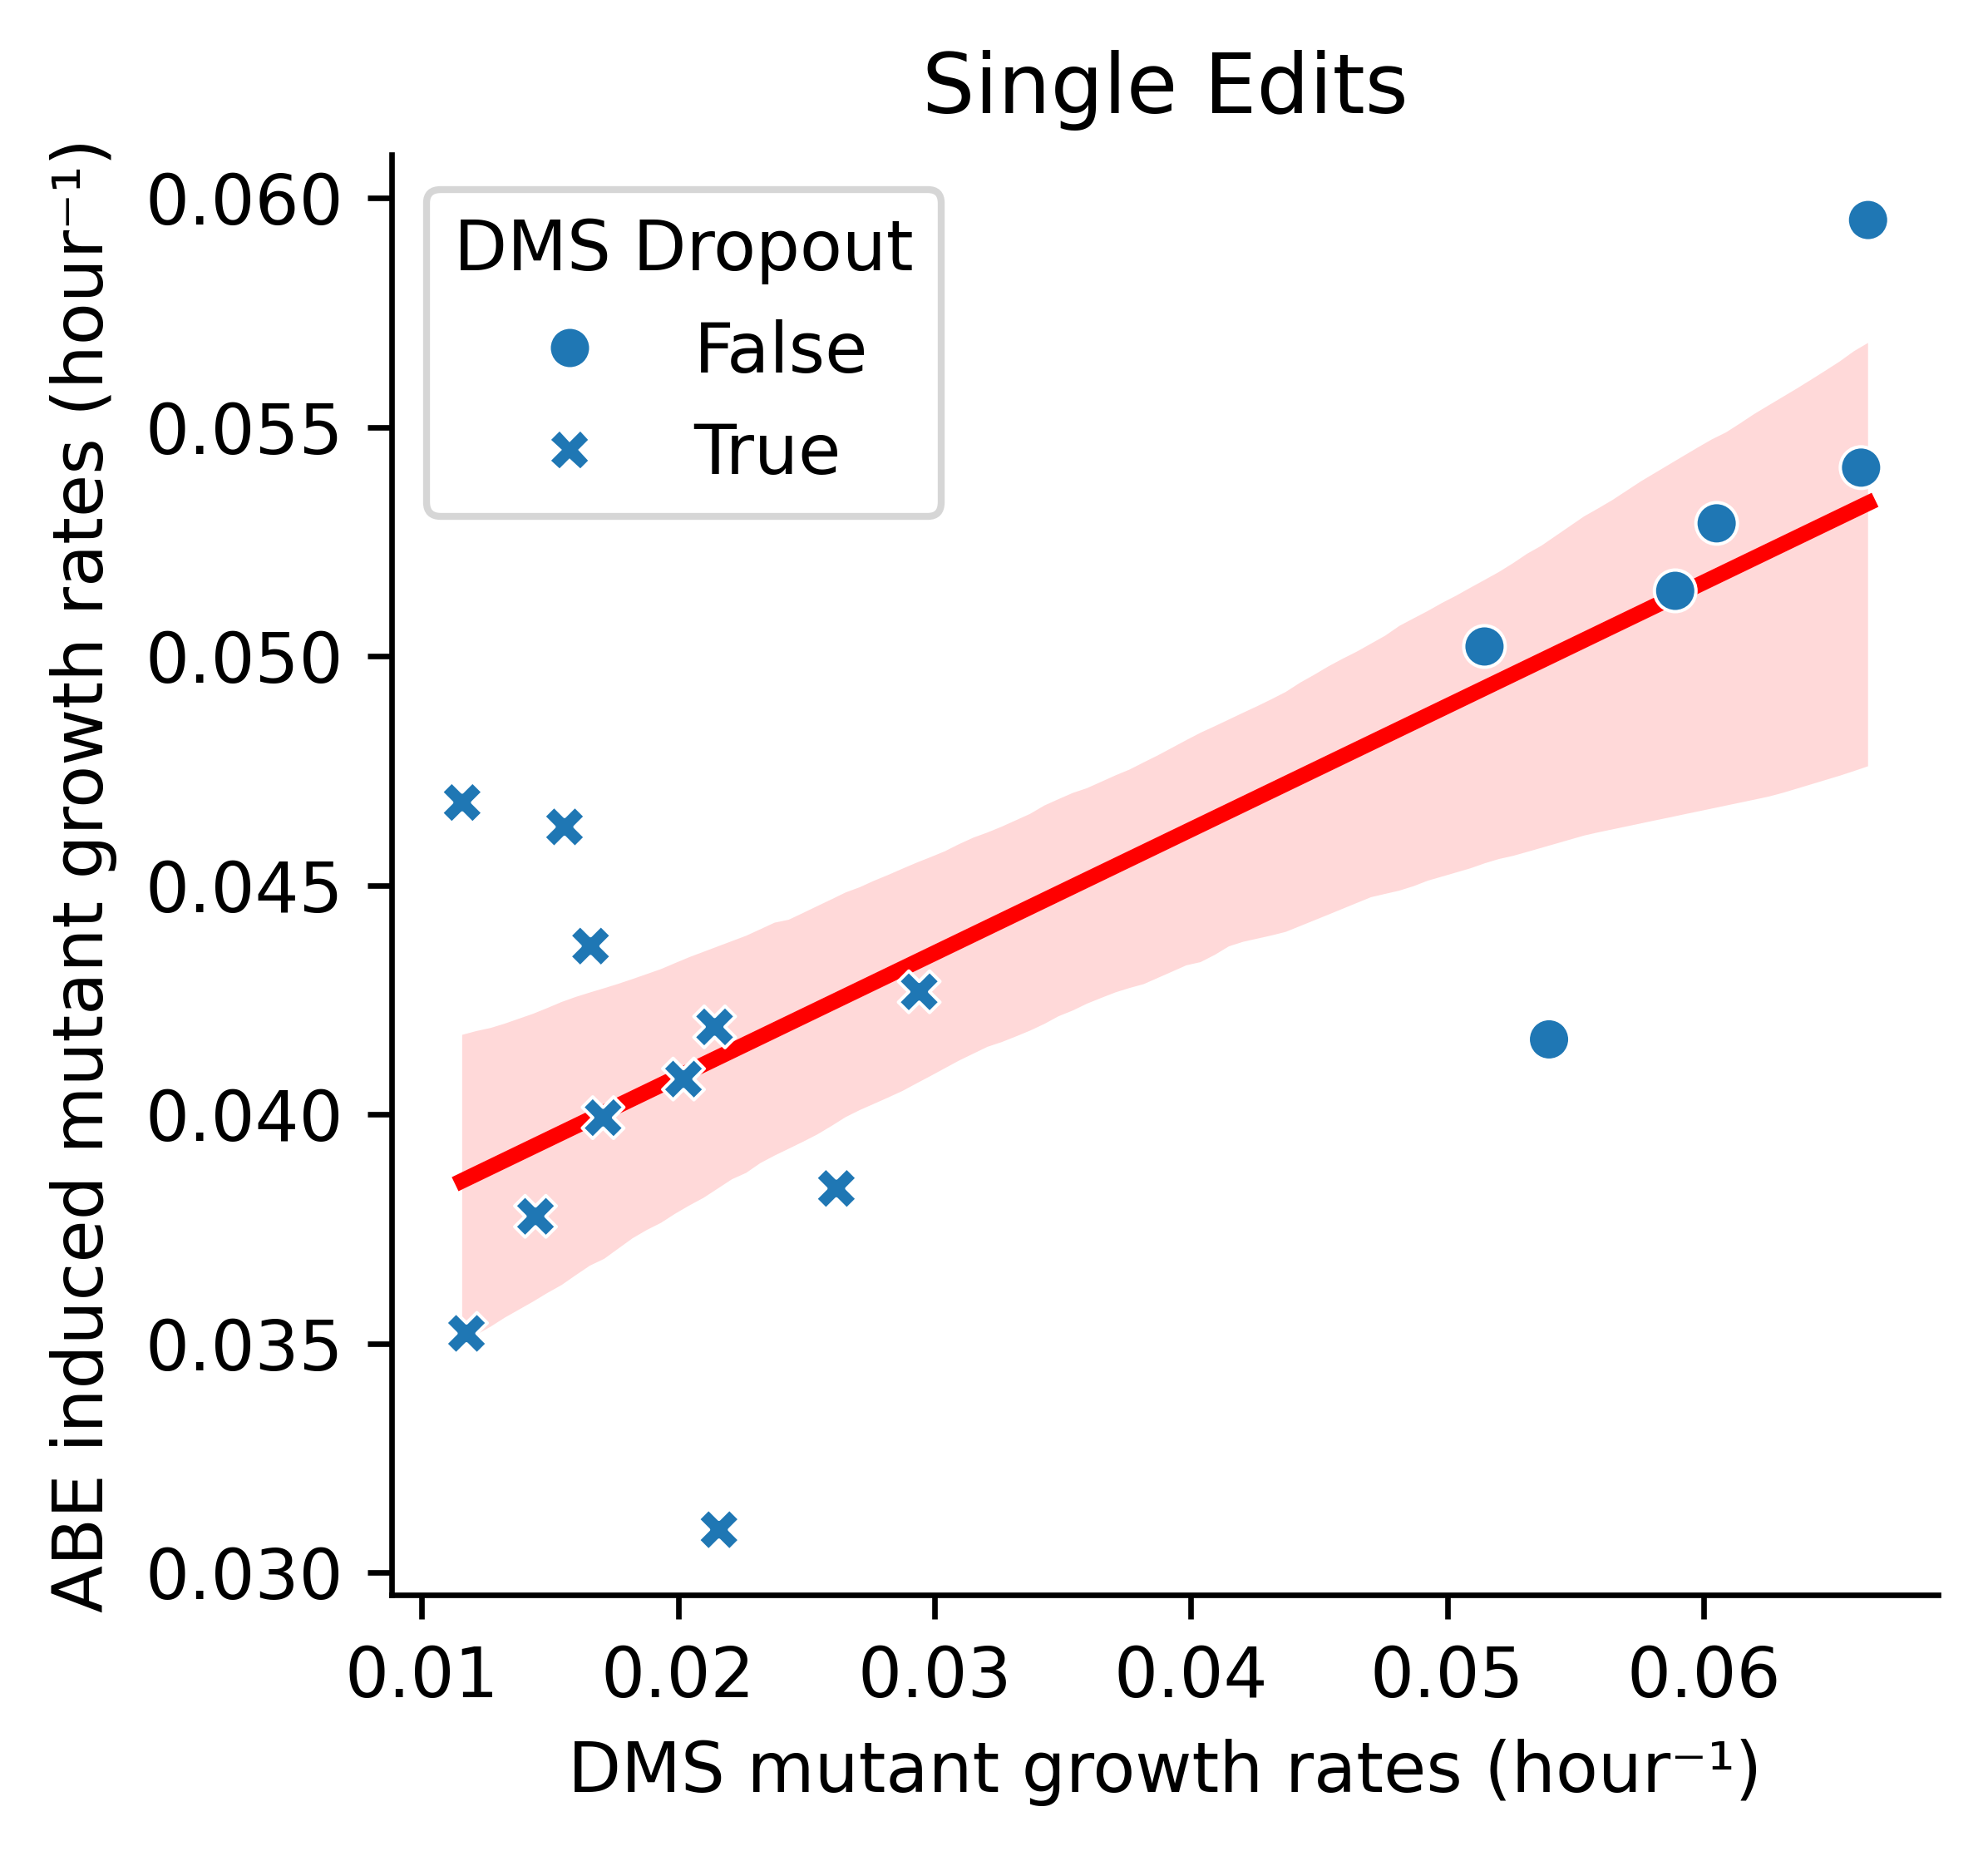

In [22]:
plt.figure(figsize=(4,3.75), dpi=600)
Veri_sgRNA = sns.regplot(x='DMS_Predicedted_Mutations', y='Veri_mut_growthrate', scatter_kws={'alpha':0} , line_kws={"color": "red", "zorder":0},data=Veri_DF_single)
Veri2= sns.scatterplot(x='DMS_Predicedted_Mutations', y='Veri_mut_growthrate' , style='DMS_Dropout', data=Veri_DF_single)
Veri_sgRNA.set(xlabel='DMS mutant growth rates (hour⁻¹)', ylabel='ABE induced mutant growth rates (hour⁻¹)', title='Single Edits')
#plt.vlines(0.04475679365950399, Veri_DF['Veri_growthrate_D6'].min(), Veri_DF['Veri_growthrate_D6'].max(), linestyles="--", color='grey')
Veri2.legend(title='DMS Dropout')
sns.despine()
#Veri_sgRNA.get_figure().savefig("Single Veri mut vs DMS mut  Regression GR0614.png" , bbox_inches='tight', transparent=True) 

In [29]:
Veri_DF_single.loc[Veri_DF_single['mut']=='F283L', ['mut', 'Veri_mut_growthrate', 'DMS_Predicedted_Mutations']]

,mut,Veri_mut_growthrate,DMS_Predicedted_Mutations
13,F283L,0.041638,0.053971
